In [1]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf

from sklearn import model_selection
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

from keras import layers
from keras.models import Sequential

from IPython.display import clear_output
from keras.utils.vis_utils import plot_model

from skimage import feature
from skimage.filters import gaussian

In [2]:
new_model = tf.keras.models.load_model('saved_model/lstm_marmousi2.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2800, 600)         724800    
_________________________________________________________________
batch_normalization (BatchNo (None, 2800, 600)         2400      
_________________________________________________________________
re_lu (ReLU)                 (None, 2800, 600)         0         
_________________________________________________________________
dense (Dense)                (None, 2800, 150)         90150     
_________________________________________________________________
dense_1 (Dense)              (None, 2800, 50)          7550      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2800, 600)         842400    
_________________________________________________________________
dense_2 (Dense)              (None, 2800, 1)           6

In [3]:
filename = '../data/raw/MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

VP = marmousi_cube['Vp']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']

In [4]:
all_traces = np.arange(seismic.shape[1], dtype=int)
traces_marmousi2_train = np.linspace(0, seismic.shape[1]-1, 101, dtype=int)
validation_and_test = [trace for trace in all_traces if trace not in traces_marmousi2_train]
    
validation_and_test_traces = []
for trace in all_traces:
    if trace not in traces_marmousi2_train:
        validation_and_test_traces.append(trace)
    
traces_marmousi2_validation_indices = np.linspace(0, len(validation_and_test_traces)-1, 1350, dtype=int)
    
traces_marmousi2_validation = []
for index in traces_marmousi2_validation_indices:
    traces_marmousi2_validation.append(validation_and_test_traces[index])
        
traces_marmousi2_test = [trace for trace in validation_and_test if trace not in traces_marmousi2_validation]

n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,135)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)

In [5]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)

pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)

In [6]:
X_train = np.transpose(seismic_norm[:,train_wells_loc[0:50]])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc[0:50]])
X_train = np.expand_dims(X_train,axis=2)
Y_train = np.expand_dims(Y_train,axis=2)


X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=2)
Y_valid = np.expand_dims(Y_valid,axis=2)

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=2)
Y_test = np.expand_dims(Y_test,axis=2)

In [7]:
X_predict = np.zeros(Y_test.shape[0:2]) 

X_predict.shape

for i in range(round((X_predict.shape[0])/50)):
    start_,stop_ = (i*50),(i+1)*50
    if start_ >= X_predict.shape[0]:
        start_ = X_predict.shape[0]
    if stop_ >= X_predict.shape[0]:
        stop_ = X_predict.shape[0]    
    #print(start_,stop_ )
    X_predict[start_:stop_,:] =new_model(X_test[start_:stop_,:])[:,:,0]
X_predict = np.transpose(X_predict)

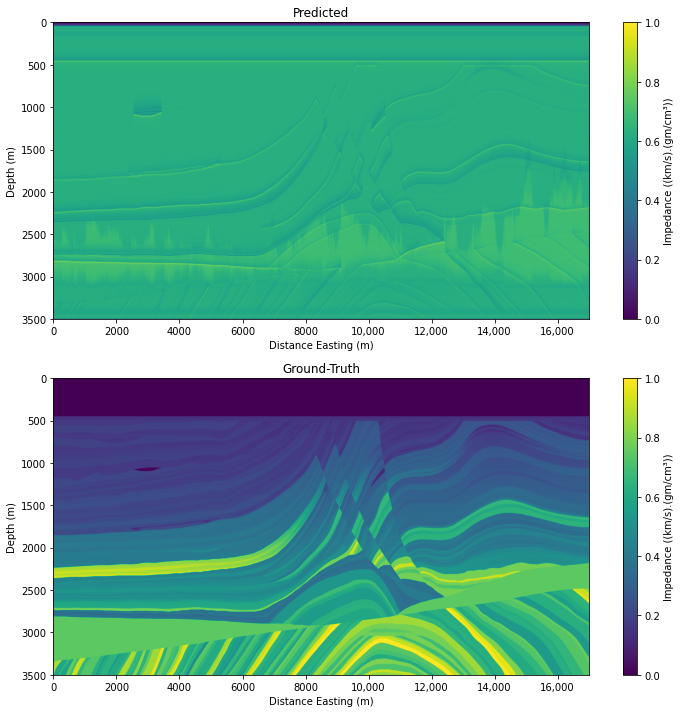

In [12]:
vmin, vmax = np.transpose(Y_test[:,:,0]).min(), np.transpose(Y_test[:,:,0]).max()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
imcolor = ax1.imshow(X_predict, vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax1, label="Impedance ((km/s).(gm/cm³))")
ax1.set_aspect('auto')
ax1.set_xlabel('Distance Easting (m)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Predicted')
ax1.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

ax2.imshow(np.transpose(Y_test[:,:,0]), vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
fig.colorbar(imcolor, ax=ax2, label="Impedance ((km/s).(gm/cm³))")
ax2.set_aspect('auto')
ax2.set_xlabel('Distance Easting (m)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Ground-Truth')
ax2.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',') if int(y)>9999 else int(y)))

plt.show()

In [9]:
from sklearn.metrics import r2_score

AI_pred = X_predict.transpose()
AI_act = Y_test[:,:,0]

original_shape = np.expand_dims(AI_pred, axis=2)
    
pred_image = np.expand_dims(AI_pred, axis=2)
pred_image = (pred_image - np.min(pred_image)) / (np.max(pred_image) - np.min(pred_image))
pred_image = pred_image.reshape(original_shape.shape)
pred_image = (pred_image).astype('float32')
    
act_image = np.expand_dims(AI_act, axis=2)
act_image = (act_image - np.min(act_image)) / (np.max(act_image) - np.min(act_image))
act_image = act_image.reshape(original_shape.shape)
act_image = (act_image).astype('float32')
    
ssim = tf.image.ssim(act_image, pred_image, max_val=1).numpy()
print('SSIM: {:0.4f}'.format(ssim))

AI_pred_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
AI_act_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
for i in range(len(traces_marmousi2_test)):
    AI_pred_partial[i] = X_predict.transpose()[traces_marmousi2_test[i]]
    AI_act_partial[i] = Y_test[traces_marmousi2_test[i],:,0]
    
print('r^2 score: {:0.4f}'.format(r2_score(AI_act_partial.T, AI_pred_partial.T)))
print('MSE: {:0.4f}'.format(np.sum((AI_pred_partial-AI_act_partial).ravel()**2)/AI_pred_partial.size))
print('MAE: {:0.4f}'.format(np.sum(np.abs(AI_pred_partial - AI_act_partial)/AI_pred_partial.size)))
print('MedAE: {:0.4f}'.format(np.median(np.abs(AI_pred_partial - AI_act_partial))))

SSIM: 0.6122
r^2 score: -0.7123
MSE: 0.1143
MAE: 0.2846
MedAE: 0.2678


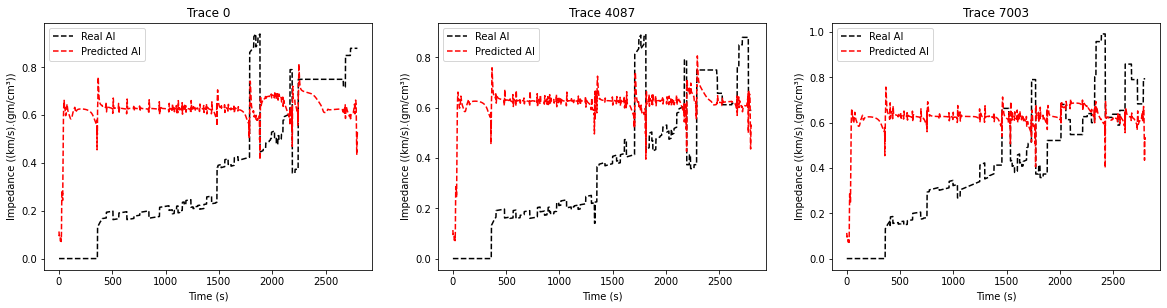

In [13]:
test_imp = Y_test[:,:,0].T

n = 3
plt.figure(figsize=(20, 10))
plot_traces = [0, 4087, 7003]
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("Trace {0}".format(plot_traces[i - 1]))
    plt.plot(test_imp[:, plot_traces[i-1]], '--k')
    plt.plot(X_predict[:, plot_traces[i-1]], '--r')
    plt.legend(['Real AI', 'Predicted AI'])
    plt.xlabel("Time (s)")
    plt.ylabel("Impedance ((km/s).(gm/cm³))")
plt.show()